In [14]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lgb_evaluation
import json

In [2]:
from importlib import reload

## Loading MLG ULB Dataset


In [3]:
import pandas as pd

train_data_raw = pd.read_csv("mlg_ulb_train.csv")
test_data_raw = pd.read_csv("mlg_ulb_test.csv")

In [4]:
train_data = train_data_raw.copy()
test_data = test_data_raw.copy()

### Preprocessing


In [5]:
from sklearn.preprocessing import StandardScaler

# normalize Amount
train_data["normAmount"] = StandardScaler().fit_transform(
    train_data_raw["Amount"].values.reshape(-1, 1)
)
# remove Amount, Time
train_data = train_data.drop(["Amount", "Time"], axis=1)
train_data.head()

# normalize Amount
test_data["normAmount"] = StandardScaler().fit_transform(
    test_data_raw["Amount"].values.reshape(-1, 1)
)
# remove Amount, Time
test_data = test_data.drop(["Amount", "Time"], axis=1)
test_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,1.914027,-0.490068,-0.326111,0.604711,-0.850136,-0.736319,-0.524058,-0.088614,1.091125,0.093484,...,0.210958,0.639338,0.147523,0.073654,-0.318378,0.350612,-0.023843,-0.037139,0,-0.114558
1,2.152696,-0.036161,-2.231811,0.091766,0.537612,-1.368103,0.613327,-0.455252,0.291814,0.253161,...,0.017153,0.063242,-0.034561,-0.626866,0.249213,0.773931,-0.137115,-0.090611,0,-0.255699
2,-4.034795,2.305079,-1.461693,-0.729887,-1.528750,-1.225679,-0.893354,1.622522,1.291998,-0.040956,...,-0.392557,-0.787599,0.343468,-0.090331,0.248287,-0.238524,0.266484,-0.062236,0,-0.284894
3,-1.668741,1.168055,0.249642,-1.268497,0.785923,-0.663959,0.859433,0.068111,-0.144183,0.043288,...,-0.247544,-0.592537,-0.286694,-0.378856,-0.077429,0.067608,-0.278962,-0.064193,0,-0.287753
4,-0.550678,-0.429004,-1.291893,-0.414409,-0.292229,0.071843,2.426068,-0.212730,0.412374,-1.939969,...,0.003032,-0.645783,0.877016,-1.228529,-0.036281,-0.110610,-0.098380,0.095985,0,1.539310


In [6]:
X_train, y_train, X_test, y_test = (
    train_data.drop(["Class"], axis=1),
    train_data["Class"],
    test_data.drop(["Class"], axis=1),
    test_data["Class"],
)

In [7]:
X_test, y_test = test_data.drop(["Class"], axis=1), test_data["Class"]

In [8]:
from collections import Counter
from lgb_evaluation import get_fraud_percentage

get_fraud_percentage(Counter(train_data["Class"]))
get_fraud_percentage(Counter(test_data["Class"]))

0.1830% fraud -- 417 fraud, 227428 nonfraud, 227845 total
0.1317% fraud -- 75 fraud, 56887 nonfraud, 56962 total


# To upsample minority class


In [9]:
# can duplicate minority class N times
from lgb_evaluation import duplicate_minority_class

new_dataset = duplicate_minority_class(train_data, N=10)
get_fraud_percentage(Counter(new_dataset["Class"]))

1.8005% fraud -- 4170 fraud, 227428 nonfraud, 231598 total


In [10]:
# can oversample minority class with weight
from imblearn.over_sampling import RandomOverSampler

num_fraud, denom_nonfraud = (
    10,
    90,
)  # <- this will result in fraction of fraud in new dataset = (num_fraud/(num_fraud+denom_nonfraud))
sampling_strategy = float(num_fraud / denom_nonfraud)
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
get_fraud_percentage(Counter(y_resampled))

9.9997% fraud -- 25269 fraud, 227428 nonfraud, 252697 total


## To Train LightGBM


In [11]:
# best_params = json.load(open("best_params.json"))
from lgb_evaluation import get_best_params

best_params = get_best_params(X_train, y_train)

# save_params(best_params, "best_params.json")

[I 2025-01-02 15:53:41,777] A new study created in memory with name: no-name-dfaa86fd-3d5e-4e31-96fa-d094547dab3c
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:53:43,991] Trial 0 finished with value: 0.9252879615222165 and parameters: {'num_leaves': 24, 'learning_rate': 0.07624286563944717, 'feature_fraction': 0.8773120860471781, 'bagging_fraction': 0.7231585265340652, 'min_data_in_leaf': 89, 'lambda_l1': 4.425826806213007e-05, 'lambda_l2': 0.007855879185531328}. Best is trial 0 with value: 0.9252879615222165.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:53:46,328] Trial 1 finished with value: 0.9796982566503254 and parameters: {'num_leaves': 50, 'learning_rate': 0.037519272209313954, 'feature_fraction': 0.7878027215046902, 'bagging_fraction': 0.8794084636275706, 'min_data_in_leaf': 25, 'lambda_l1': 6.108843077140434e-05, 'lambda_l2': 0.44495979224400245}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:53:48,351] Trial 2 finished with value: 0.9740677275183923 and parameters: {'num_leaves': 33, 'learning_rate': 0.011376136840866736, 'feature_fraction': 0.7335998366770622, 'bagging_fraction': 0.8664156609291602, 'min_data_in_leaf': 24, 'lambda_l1': 3.437259534106262e-06, 'lambda_l2': 0.01545407472065179}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:53:50,669] Trial 3 finished with value: 0.9740117672589061 and parameters: {'num_leaves': 40, 'learning_rate': 0.022871091535732867, 'feature_fraction': 0.7199311609972614, 'bagging_fraction': 0.8312758142332488, 'min_data_in_leaf': 68, 'lambda_l1': 0.1988165595945893, 'lambda_l2': 0.004692967630377309}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sugg

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:53:52,896] Trial 4 finished with value: 0.9698041397346645 and parameters: {'num_leaves': 44, 'learning_rate': 0.012269209581118677, 'feature_fraction': 0.8566188787304105, 'bagging_fraction': 0.7347437807211548, 'min_data_in_leaf': 31, 'lambda_l1': 6.865465217522643e-08, 'lambda_l2': 1.3872920482616131e-06}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:53:55,746] Trial 5 finished with value: 0.975116579300499 and parameters: {'num_leaves': 60, 'learning_rate': 0.022692013040993164, 'feature_fraction': 0.8206115430828651, 'bagging_fraction': 0.7908659837928724, 'min_data_in_leaf': 49, 'lambda_l1': 2.571040933451317e-05, 'lambda_l2': 0.05524442986678026}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:53:58,209] Trial 6 finished with value: 0.9222673990127984 and parameters: {'num_leaves': 28, 'learning_rate': 0.05770227233884636, 'feature_fraction': 0.7358367342341745, 'bagging_fraction': 0.8898515477553713, 'min_data_in_leaf': 98, 'lambda_l1': 1.852004064800529e-08, 'lambda_l2': 0.000535835308810138}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:00,113] Trial 7 finished with value: 0.9731757517208557 and parameters: {'num_leaves': 35, 'learning_rate': 0.012378648882960098, 'feature_fraction': 0.7668780753474682, 'bagging_fraction': 0.7745517535588718, 'min_data_in_leaf': 39, 'lambda_l1': 3.1125740162662714, 'lambda_l2': 1.446060333770465e-05}. Best is trial 1 with value: 0.9796982566503254.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:02,665] Trial 8 finished with value: 0.9719896549824977 and parameters: {'num_leaves': 52, 'learning_rate': 0.015901543029416928, 'feature_fraction': 0.80228928962155, 'bagging_fraction': 0.8297415501957048, 'min_data_in_leaf': 31, 'lambda_l1': 1.0680441084127506e-06, 'lambda_l2': 0.022679153537741085}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:04,428] Trial 9 finished with value: 0.9753286371557728 and parameters: {'num_leaves': 20, 'learning_rate': 0.012861897683052029, 'feature_fraction': 0.8470265321234156, 'bagging_fraction': 0.7402251126350222, 'min_data_in_leaf': 84, 'lambda_l1': 2.6352289561287585, 'lambda_l2': 2.075373841279631e-08}. Best is trial 1 with value: 0.9796982566503254.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004913 seconds.
You can set `force_col_wise=true` to remov

[I 2025-01-02 15:54:06,990] Trial 10 finished with value: 0.9800320654705127 and parameters: {'num_leaves': 50, 'learning_rate': 0.03954338706718902, 'feature_fraction': 0.7763928479867344, 'bagging_fraction': 0.8995953306010078, 'min_data_in_leaf': 61, 'lambda_l1': 0.0038011535865587844, 'lambda_l2': 3.631320025918142}. Best is trial 10 with value: 0.9800320654705127.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:09,369] Trial 11 finished with value: 0.9799927982887621 and parameters: {'num_leaves': 49, 'learning_rate': 0.04282195246760611, 'feature_fraction': 0.7784144239541667, 'bagging_fraction': 0.8965114334304836, 'min_data_in_leaf': 63, 'lambda_l1': 0.0030238737076385557, 'lambda_l2': 8.732420408580353}. Best is trial 10 with value: 0.9800320654705127.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:11,648] Trial 12 finished with value: 0.9804220663924436 and parameters: {'num_leaves': 53, 'learning_rate': 0.043595543174763246, 'feature_fraction': 0.7654464590975766, 'bagging_fraction': 0.8981954561436707, 'min_data_in_leaf': 63, 'lambda_l1': 0.007078659892267599, 'lambda_l2': 8.321726977241159}. Best is trial 12 with value: 0.9804220663924436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:14,350] Trial 13 finished with value: 0.9804289821497437 and parameters: {'num_leaves': 60, 'learning_rate': 0.09779708352068361, 'feature_fraction': 0.7473256923386147, 'bagging_fraction': 0.8467851564668715, 'min_data_in_leaf': 74, 'lambda_l1': 0.006551887608202627, 'lambda_l2': 9.430356288818048}. Best is trial 13 with value: 0.9804289821497437.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:16,961] Trial 14 finished with value: 0.9800244758700609 and parameters: {'num_leaves': 60, 'learning_rate': 0.09336303222156084, 'feature_fraction': 0.702894411910863, 'bagging_fraction': 0.8468516066266296, 'min_data_in_leaf': 76, 'lambda_l1': 0.018570698419437592, 'lambda_l2': 0.5128244833841049}. Best is trial 13 with value: 0.9804289821497437.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:19,449] Trial 15 finished with value: 0.9778934116430417 and parameters: {'num_leaves': 56, 'learning_rate': 0.05665287656626325, 'feature_fraction': 0.7463919092426975, 'bagging_fraction': 0.8531272800732254, 'min_data_in_leaf': 51, 'lambda_l1': 0.13831818654638284, 'lambda_l2': 0.502994207802934}. Best is trial 13 with value: 0.9804289821497437.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:22,387] Trial 16 finished with value: 0.9323100988470441 and parameters: {'num_leaves': 55, 'learning_rate': 0.09523077148479336, 'feature_fraction': 0.7567397009161758, 'bagging_fraction': 0.8175044309000294, 'min_data_in_leaf': 73, 'lambda_l1': 0.0018681936042655655, 'lambda_l2': 0.0003390588842197499}. Best is trial 13 with value: 0.9804289821497437.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:24,749] Trial 17 finished with value: 0.9787894599015514 and parameters: {'num_leaves': 45, 'learning_rate': 0.05969028220643224, 'feature_fraction': 0.813142261048799, 'bagging_fraction': 0.865671915265829, 'min_data_in_leaf': 52, 'lambda_l1': 0.052997468219658075, 'lambda_l2': 2.1007746571476535}. Best is trial 13 with value: 0.9804289821497437.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sugge

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:27,333] Trial 18 finished with value: 0.9771835560956884 and parameters: {'num_leaves': 56, 'learning_rate': 0.02556314715937331, 'feature_fraction': 0.7134764555094506, 'bagging_fraction': 0.8048004448123895, 'min_data_in_leaf': 82, 'lambda_l1': 0.0004916879274026416, 'lambda_l2': 1.1627703479849344e-05}. Best is trial 13 with value: 0.9804289821497437.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": tria

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:29,500] Trial 19 finished with value: 0.9783923382824735 and parameters: {'num_leaves': 44, 'learning_rate': 0.031206426179911165, 'feature_fraction': 0.7511864249413343, 'bagging_fraction': 0.7584104927440339, 'min_data_in_leaf': 96, 'lambda_l1': 0.39489463472438396, 'lambda_l2': 0.08831193714344922}. Best is trial 13 with value: 0.9804289821497437.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:32,090] Trial 20 finished with value: 0.9808100292802401 and parameters: {'num_leaves': 54, 'learning_rate': 0.07433768748326666, 'feature_fraction': 0.8307267145046253, 'bagging_fraction': 0.7032192988770407, 'min_data_in_leaf': 70, 'lambda_l1': 0.01620443779947399, 'lambda_l2': 8.587667735678064}. Best is trial 20 with value: 0.9808100292802401.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sugge

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:34,597] Trial 21 finished with value: 0.9797248331351036 and parameters: {'num_leaves': 55, 'learning_rate': 0.06998132308347058, 'feature_fraction': 0.8327603437213326, 'bagging_fraction': 0.7849838702476503, 'min_data_in_leaf': 71, 'lambda_l1': 0.016020174228145435, 'lambda_l2': 9.83323135964626}. Best is trial 20 with value: 0.9808100292802401.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:37,574] Trial 22 finished with value: 0.9782077761417475 and parameters: {'num_leaves': 59, 'learning_rate': 0.08184632012485876, 'feature_fraction': 0.8911751991397676, 'bagging_fraction': 0.705754716385387, 'min_data_in_leaf': 57, 'lambda_l1': 0.000668493591552973, 'lambda_l2': 1.0581716329189121}. Best is trial 20 with value: 0.9808100292802401.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:40,061] Trial 23 finished with value: 0.9751668602436779 and parameters: {'num_leaves': 53, 'learning_rate': 0.04990447509440379, 'feature_fraction': 0.7967182333479184, 'bagging_fraction': 0.700999968695697, 'min_data_in_leaf': 79, 'lambda_l1': 0.012656361481607419, 'lambda_l2': 0.15138794239314554}. Best is trial 20 with value: 0.9808100292802401.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:42,515] Trial 24 finished with value: 0.9791098900804082 and parameters: {'num_leaves': 48, 'learning_rate': 0.09987329365898982, 'feature_fraction': 0.7667652161246648, 'bagging_fraction': 0.8489462821500409, 'min_data_in_leaf': 66, 'lambda_l1': 0.6613908380255105, 'lambda_l2': 2.0203479985364643}. Best is trial 20 with value: 0.9808100292802401.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:45,265] Trial 25 finished with value: 0.9736392439590534 and parameters: {'num_leaves': 57, 'learning_rate': 0.06703868856581317, 'feature_fraction': 0.8414747581954005, 'bagging_fraction': 0.7596332496512822, 'min_data_in_leaf': 90, 'lambda_l1': 0.0002010870904603584, 'lambda_l2': 0.1404521707835875}. Best is trial 20 with value: 0.9808100292802401.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:47,104] Trial 26 finished with value: 0.9438565509096349 and parameters: {'num_leaves': 40, 'learning_rate': 0.047674259037098515, 'feature_fraction': 0.8709581156746463, 'bagging_fraction': 0.8080881000859466, 'min_data_in_leaf': 45, 'lambda_l1': 9.396659216960382, 'lambda_l2': 0.0020056371676515795}. Best is trial 20 with value: 0.9808100292802401.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:50,126] Trial 27 finished with value: 0.9803319477019111 and parameters: {'num_leaves': 53, 'learning_rate': 0.08243194300039078, 'feature_fraction': 0.8109661515199119, 'bagging_fraction': 0.877964635844304, 'min_data_in_leaf': 73, 'lambda_l1': 0.036851462544142864, 'lambda_l2': 5.91951857346108}. Best is trial 20 with value: 0.9808100292802401.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:52,643] Trial 28 finished with value: 0.980264398650401 and parameters: {'num_leaves': 46, 'learning_rate': 0.031484772216590816, 'feature_fraction': 0.8265124456730507, 'bagging_fraction': 0.8325095726459284, 'min_data_in_leaf': 57, 'lambda_l1': 0.003462135164386553, 'lambda_l2': 1.3218843420647903}. Best is trial 20 with value: 0.9808100292802401.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:55,250] Trial 29 finished with value: 0.9667403762574631 and parameters: {'num_leaves': 58, 'learning_rate': 0.07307787642421353, 'feature_fraction': 0.73127263939509, 'bagging_fraction': 0.719249441325423, 'min_data_in_leaf': 85, 'lambda_l1': 8.080098713934638e-05, 'lambda_l2': 4.48153866161774e-08}. Best is trial 20 with value: 0.9808100292802401.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:54:57,669] Trial 30 finished with value: 0.9739333448225338 and parameters: {'num_leaves': 39, 'learning_rate': 0.08216877970032341, 'feature_fraction': 0.8644644375174664, 'bagging_fraction': 0.8678598074542497, 'min_data_in_leaf': 90, 'lambda_l1': 1.4791539505207947e-05, 'lambda_l2': 0.21604840310782508}. Best is trial 20 with value: 0.9808100292802401.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:00,123] Trial 31 finished with value: 0.9811041597064327 and parameters: {'num_leaves': 53, 'learning_rate': 0.08002791937103076, 'feature_fraction': 0.804751021803042, 'bagging_fraction': 0.8811704990496543, 'min_data_in_leaf': 72, 'lambda_l1': 0.0415095495044617, 'lambda_l2': 6.996870976993741}. Best is trial 31 with value: 0.9811041597064327.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:02,459] Trial 32 finished with value: 0.9796192841415001 and parameters: {'num_leaves': 52, 'learning_rate': 0.06498969142553918, 'feature_fraction': 0.7854812095561786, 'bagging_fraction': 0.8825748089239086, 'min_data_in_leaf': 67, 'lambda_l1': 0.09977213201297826, 'lambda_l2': 8.826823255522086}. Best is trial 31 with value: 0.9811041597064327.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:04,599] Trial 33 finished with value: 0.9816112325772032 and parameters: {'num_leaves': 47, 'learning_rate': 0.051855580147315554, 'feature_fraction': 0.7949410245122969, 'bagging_fraction': 0.8737083280272243, 'min_data_in_leaf': 78, 'lambda_l1': 0.005984563266578669, 'lambda_l2': 0.8945158599406965}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.su

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:07,358] Trial 34 finished with value: 0.980280927616862 and parameters: {'num_leaves': 47, 'learning_rate': 0.052169252806593895, 'feature_fraction': 0.7970757569169103, 'bagging_fraction': 0.859635208894141, 'min_data_in_leaf': 78, 'lambda_l1': 0.0005431291562356793, 'lambda_l2': 0.6615971561926735}. Best is trial 33 with value: 0.9816112325772032.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:10,127] Trial 35 finished with value: 0.927657747988368 and parameters: {'num_leaves': 51, 'learning_rate': 0.0775968742130055, 'feature_fraction': 0.8386411883411647, 'bagging_fraction': 0.8738506669034206, 'min_data_in_leaf': 70, 'lambda_l1': 0.0014622354344273325, 'lambda_l2': 0.023765632464901085}. Best is trial 33 with value: 0.9816112325772032.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:12,493] Trial 36 finished with value: 0.9795038426973713 and parameters: {'num_leaves': 42, 'learning_rate': 0.08753193321249422, 'feature_fraction': 0.8547578818647095, 'bagging_fraction': 0.8353988300675, 'min_data_in_leaf': 77, 'lambda_l1': 0.6309619227448087, 'lambda_l2': 2.2674116717401285}. Best is trial 33 with value: 0.9816112325772032.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:15,022] Trial 37 finished with value: 0.9479648482700274 and parameters: {'num_leaves': 49, 'learning_rate': 0.06291815091709352, 'feature_fraction': 0.8207743323506269, 'bagging_fraction': 0.8815837835614766, 'min_data_in_leaf': 82, 'lambda_l1': 0.04349464378185381, 'lambda_l2': 0.007265410009180497}. Best is trial 33 with value: 0.9816112325772032.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:17,800] Trial 38 finished with value: 0.9602110202514358 and parameters: {'num_leaves': 58, 'learning_rate': 0.073298141549436, 'feature_fraction': 0.8076851575406353, 'bagging_fraction': 0.844486059842439, 'min_data_in_leaf': 88, 'lambda_l1': 0.00016324272406891975, 'lambda_l2': 4.241299622786837e-05}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.s

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:19,885] Trial 39 finished with value: 0.9677246880630701 and parameters: {'num_leaves': 36, 'learning_rate': 0.035950594115883625, 'feature_fraction': 0.885604073579156, 'bagging_fraction': 0.8574447088972722, 'min_data_in_leaf': 94, 'lambda_l1': 0.2525739255873049, 'lambda_l2': 0.03764190007811034}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sugg

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:22,404] Trial 40 finished with value: 0.9148894996063867 and parameters: {'num_leaves': 54, 'learning_rate': 0.05497281864658222, 'feature_fraction': 0.7847758426654929, 'bagging_fraction': 0.8222399654258905, 'min_data_in_leaf': 67, 'lambda_l1': 5.527322523751161e-07, 'lambda_l2': 0.0019287636701343812}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

[I 2025-01-02 15:55:24,561] Trial 41 finished with value: 0.9808661955083514 and parameters: {'num_leaves': 30, 'learning_rate': 0.04508205170592879, 'feature_fraction': 0.7663148865575331, 'bagging_fraction': 0.8885648025950689, 'min_data_in_leaf': 62, 'lambda_l1': 0.007515171373960381, 'lambda_l2': 2.8705450329460525}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:26,646] Trial 42 finished with value: 0.9809261571592548 and parameters: {'num_leaves': 29, 'learning_rate': 0.04768977316943175, 'feature_fraction': 0.7387854985152632, 'bagging_fraction': 0.8902514652768617, 'min_data_in_leaf': 58, 'lambda_l1': 0.008042316723781834, 'lambda_l2': 0.3613145710990143}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:28,489] Trial 43 finished with value: 0.9771841128617705 and parameters: {'num_leaves': 28, 'learning_rate': 0.03441940872681446, 'feature_fraction': 0.7325748100666609, 'bagging_fraction': 0.886911491723409, 'min_data_in_leaf': 57, 'lambda_l1': 0.022475714155057537, 'lambda_l2': 0.20081471744678595}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:30,705] Trial 44 finished with value: 0.9805940897515177 and parameters: {'num_leaves': 30, 'learning_rate': 0.04511167221020483, 'feature_fraction': 0.7923311603614038, 'bagging_fraction': 0.8894275634680057, 'min_data_in_leaf': 61, 'lambda_l1': 0.001075433000352351, 'lambda_l2': 3.3579636870909835}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007300 seconds.
You can set `force_col_wise=true` to remov

[I 2025-01-02 15:55:32,972] Trial 45 finished with value: 0.9791906167119224 and parameters: {'num_leaves': 23, 'learning_rate': 0.04073107272626305, 'feature_fraction': 0.7764424610082857, 'bagging_fraction': 0.8708160477397878, 'min_data_in_leaf': 48, 'lambda_l1': 0.09585409843327443, 'lambda_l2': 0.9154755718441785}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sugg

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:35,430] Trial 46 finished with value: 0.980485417814637 and parameters: {'num_leaves': 31, 'learning_rate': 0.050043646437189636, 'feature_fraction': 0.720850104390183, 'bagging_fraction': 0.8945284796395426, 'min_data_in_leaf': 20, 'lambda_l1': 0.007266909275240515, 'lambda_l2': 0.4635121827642974}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sugg

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:37,207] Trial 47 finished with value: 0.9756921645264355 and parameters: {'num_leaves': 35, 'learning_rate': 0.010081882022322354, 'feature_fraction': 0.8036214564664325, 'bagging_fraction': 0.7356120501360403, 'min_data_in_leaf': 64, 'lambda_l1': 0.008902353273203795, 'lambda_l2': 3.004036865074446}. Best is trial 33 with value: 0.9816112325772032.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.7, 0.9),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:147: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.7, 0.9),


[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:39,113] Trial 48 finished with value: 0.9793074078327302 and parameters: {'num_leaves': 26, 'learning_rate': 0.018470084718637182, 'feature_fraction': 0.7597214408674101, 'bagging_fraction': 0.864446812187666, 'min_data_in_leaf': 40, 'lambda_l1': 1.4109160456130896, 'lambda_l2': 0.053141378701128686}. Best is trial 33 with value: 0.9816112325772032.
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
/Users/marylau/Desktop/gupta_group_ra/Code/lgb_evaluation.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.sug

[LightGBM] [Info] Number of positive: 278, number of negative: 151618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 29
[LightGBM] [Info] Number of positive: 278, number of negative: 151619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [In

[I 2025-01-02 15:55:41,128] Trial 49 finished with value: 0.9787215938545465 and parameters: {'num_leaves': 37, 'learning_rate': 0.027631974250466353, 'feature_fraction': 0.8231221922482991, 'bagging_fraction': 0.8756201261534362, 'min_data_in_leaf': 54, 'lambda_l1': 0.06532283341885577, 'lambda_l2': 0.26254411206134}. Best is trial 33 with value: 0.9816112325772032.


In [ ]:
from lgb_evaluation import save_params

save_params(best_params, "best_params.json")

# Evaluate LGB model over multiple seeds


[LightGBM] [Warning] lambda_l1 is set=0.005984563266578669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005984563266578669
[LightGBM] [Warning] feature_fraction is set=0.7949410245122969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7949410245122969
[LightGBM] [Warning] bagging_fraction is set=0.8737083280272243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737083280272243
[LightGBM] [Warning] lambda_l2 is set=0.8945158599406965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8945158599406965
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] lambda_l1 is set=0.005984563266578669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005984563266578669
[LightGBM] [Warning] feature_fraction is set=0.7949410245122969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7949410245122969
[LightGBM] [War

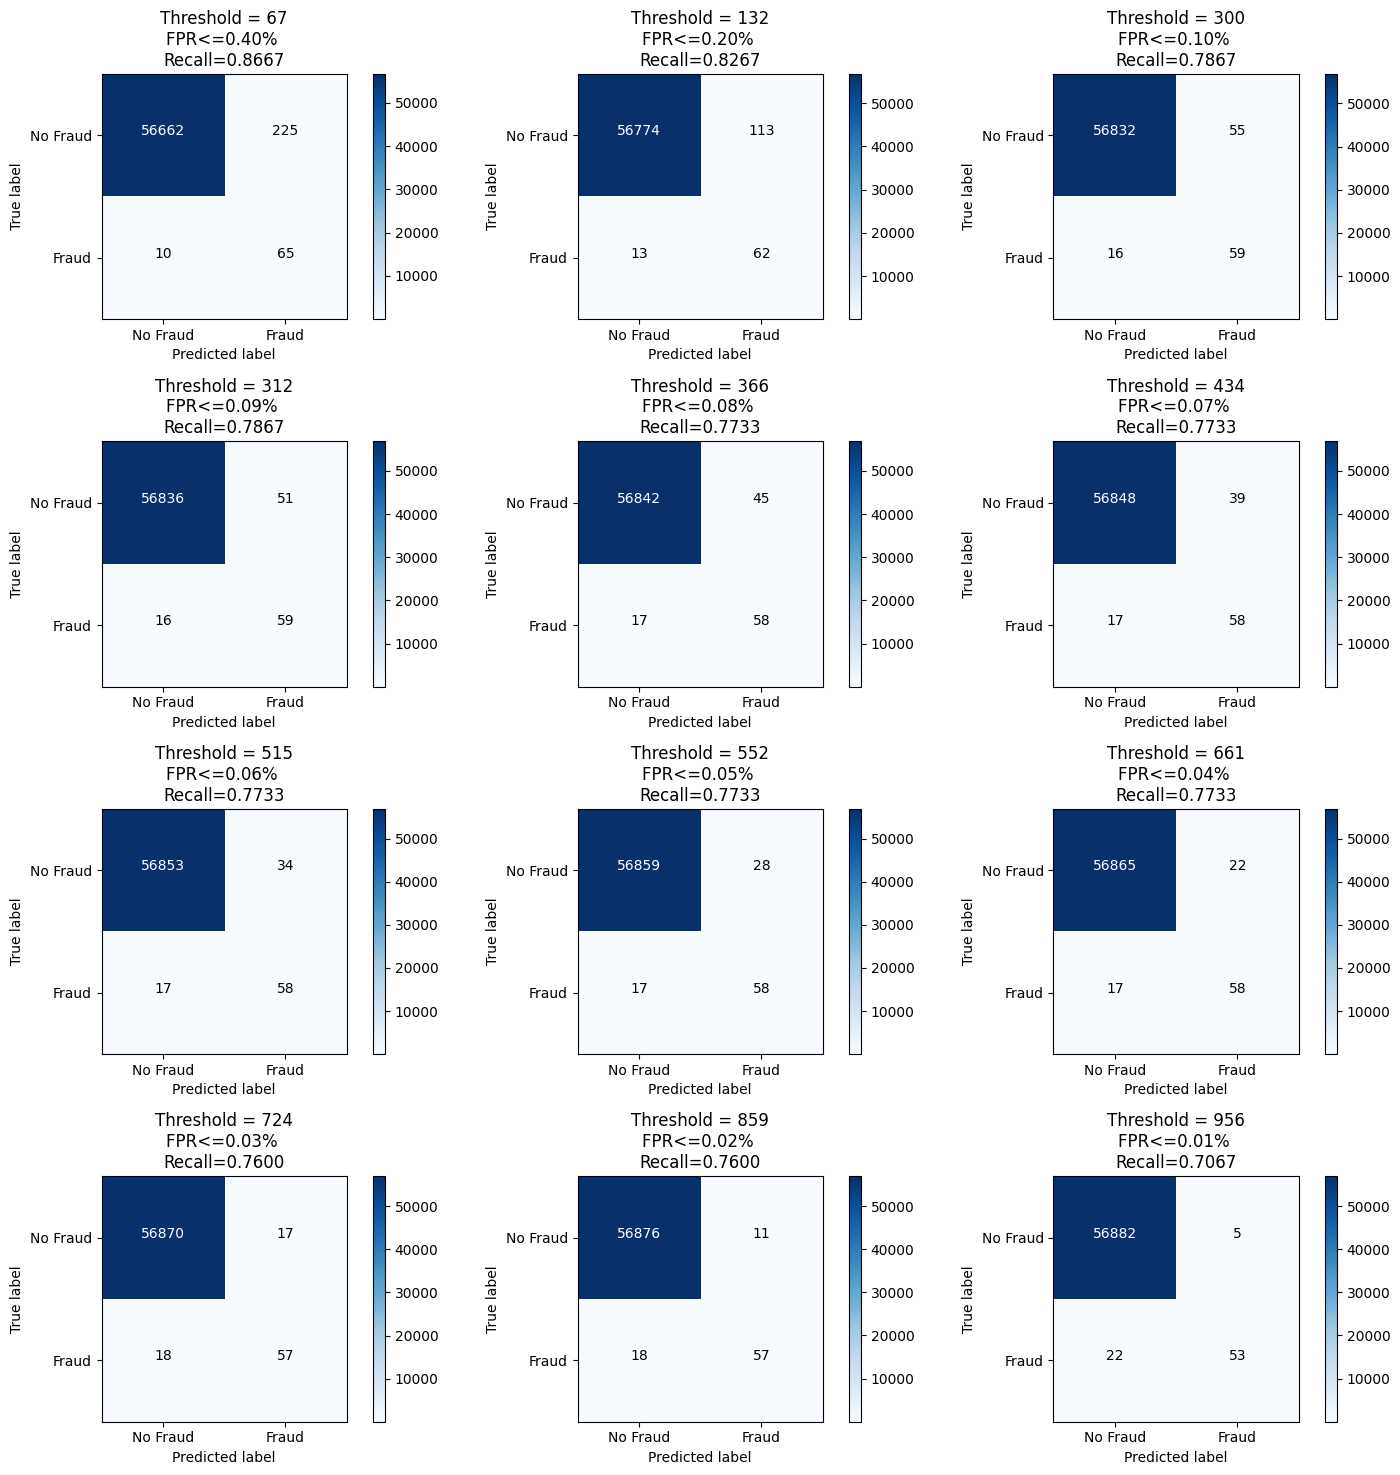

In [ ]:
reload(lgb_evaluation)
from lgb_evaluation import evaluate_model_helper
from lgb_evaluation import calculate_partial_auc

NUM_SEEDS = 1  ## CHANGE THIS!!!
results_across_seeds = np.zeros((NUM_SEEDS, 12, 3))
partial_auc_across_seeds = []
# ave_partial_auc = 0
# ave_auc = 0


for seed in range(NUM_SEEDS):
    model = lgb.LGBMClassifier(
        **best_params, n_estimators=100, random_state=seed, class_weight="balanced"
    )
    model.fit(X_train, y_train)
    results = evaluate_model_helper(
        X_test, y_test, model, viz=True
    )  # <- SET TO FALSE TO NOT SEE THE CONFUSION MATRICES
    results_across_seeds[seed] = results

    partial_auc = calculate_partial_auc(y_test, model.predict_proba(X_test)[:, 1])
    partial_auc_across_seeds.append(partial_auc)  # partial auc at fpr threshold = 0.1%


columns = ["score_threshold", "fpr %", "recall %"]
averaged_results = np.mean(results_across_seeds, axis=0)
averaged_df = pd.DataFrame(averaged_results, columns=columns)

ave_partial_auc = np.mean(partial_auc_across_seeds)
ave_partial_auc_str = f"{ave_partial_auc:.4e}"

In [19]:
averaged_df

,score_threshold,fpr %,recall %
0,956.0,0.01,70.67
1,859.0,0.02,76.00
2,724.0,0.03,76.00
3,661.0,0.04,77.33
4,552.0,0.05,77.33
5,515.0,0.06,77.33
6,434.0,0.07,77.33
7,366.0,0.08,77.33
8,312.0,0.09,78.67
9,300.0,0.10,78.67


In [20]:
ave_partial_auc_str

'6.4643e-04'